In [1]:
import torch
import matplotlib.pyplot as plt
from netcal.metrics import ECE, ACE

import pickle
import random

from utils_notebook import f_probs_ovr_poe_logits_weighted, modal_probs_decreasing, modal_probs_average, modal_probs_decreasing_count, modal_probs_decreasing_relative

/home/metod/miniconda3/envs/dvit/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = 'DVT_Deit_small'

In [3]:
with open(f'output/{MODEL}.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
logits, targets, anytime_classification = data
targets = targets.cpu()

In [5]:
# type(logits), logits.shape, type(targets), targets.shape, type(anytime_classification), len(anytime_classification)

## 1 Anytime Performance

In [6]:
L = len(logits)
N = logits.shape[1]

In [7]:
L, N

(3, 50000)

In [8]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [9]:
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

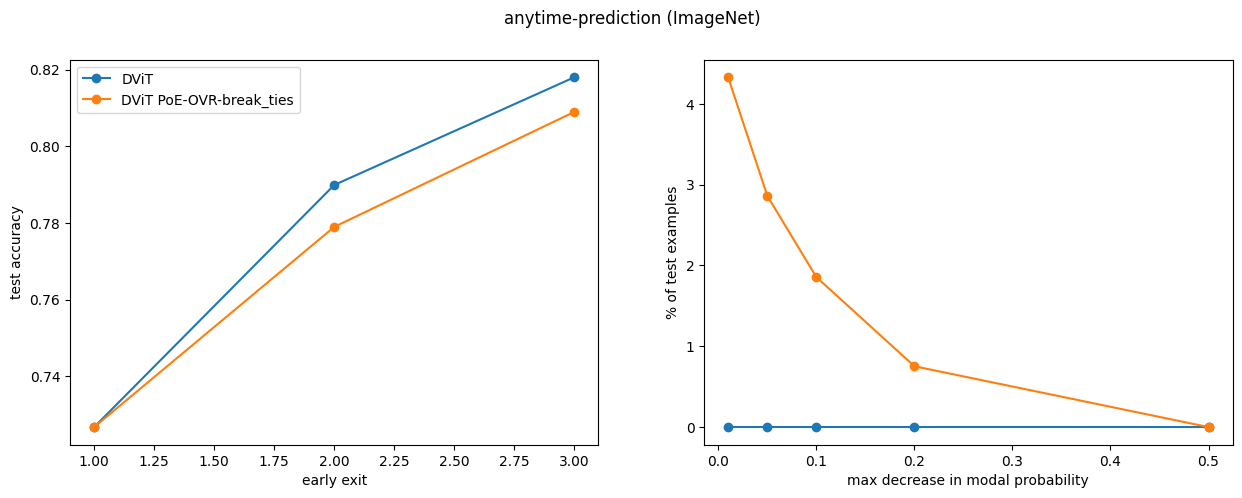

In [10]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='DViT', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='DViT PoE-OVR-break_ties', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'DViT'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'DViT PoE-OVR-break_ties'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction (ImageNet)')
plt.show()

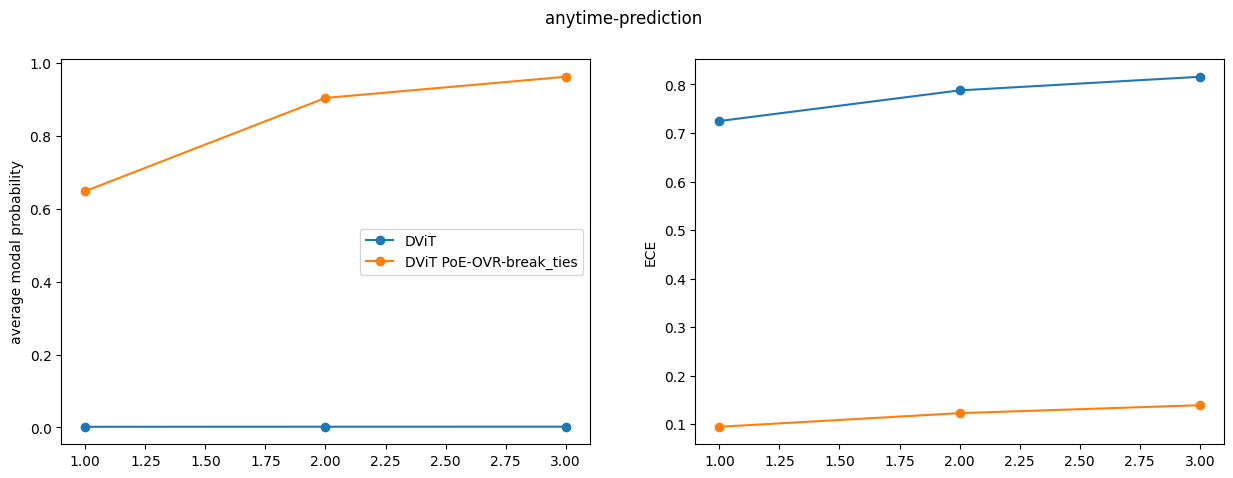

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'DViT'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'DViT PoE-OVR-break_ties'),
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L)
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, modal_probs.numpy(), marker='o', label=label)
    ax[1].plot(early_exits, ece, marker='o', label=label)
ax[0].legend()
ax[0].set_ylabel('average modal probability')
ax[1].set_ylabel('ECE')


plt.suptitle('anytime-prediction')
plt.show()

In [17]:
l, i = 2, 100
probs[l, i, :].shape, probs[l, i, :].sum(), probs[l, i, :].max()

(torch.Size([1000]), tensor(1.), tensor(0.0023))

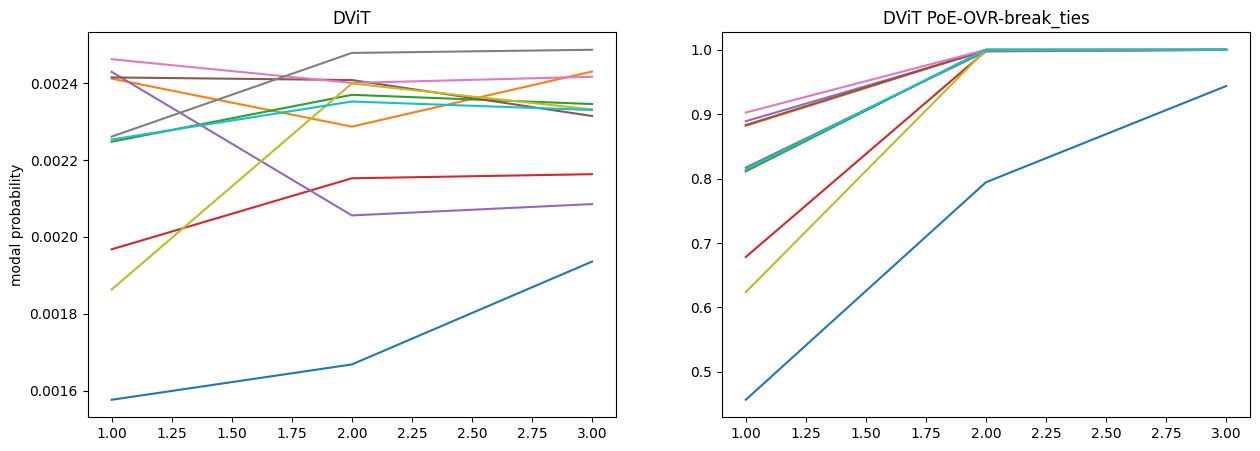

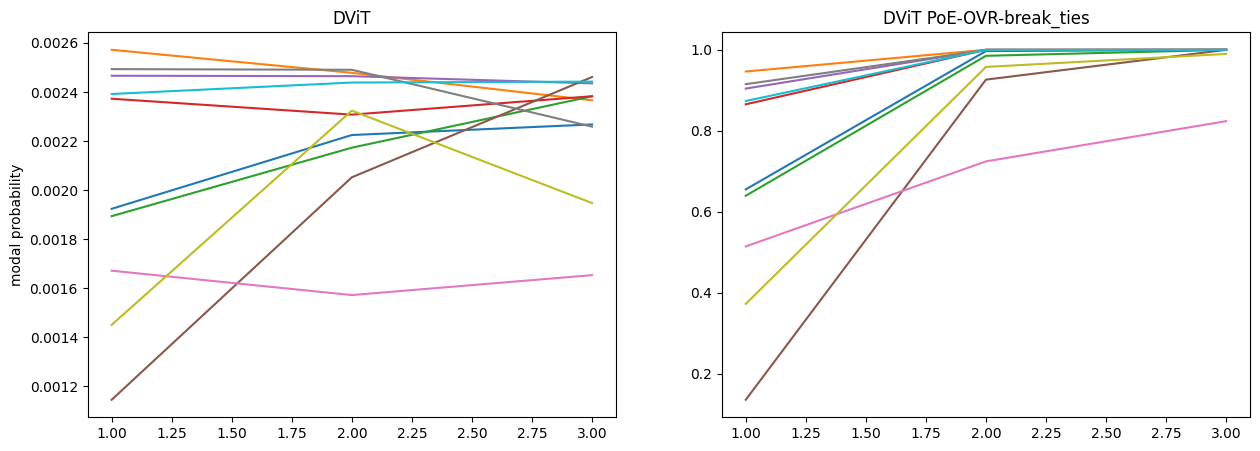

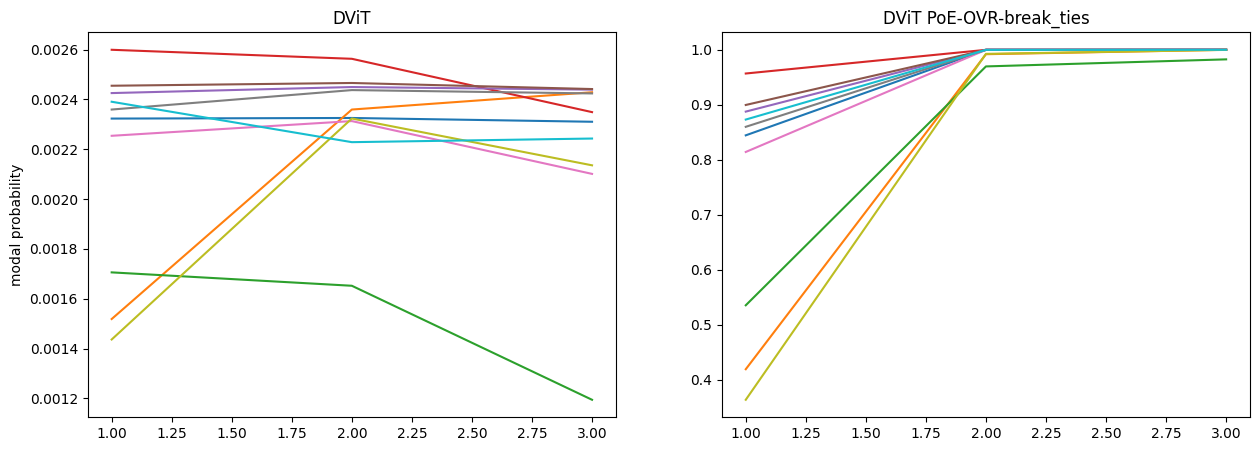

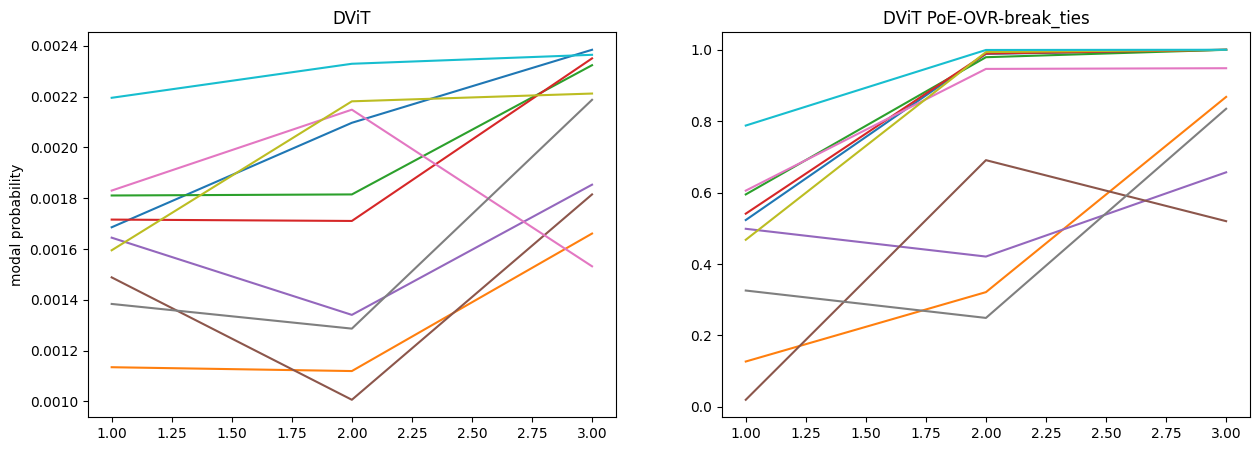

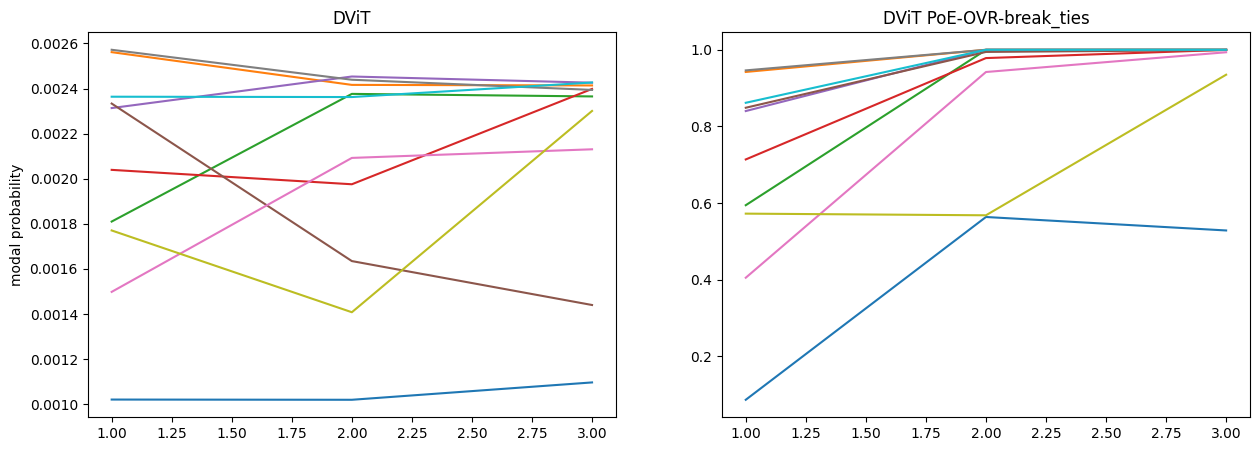

In [18]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    samples = random.sample(range(N), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('DViT')
    ax[1].set_title('DViT PoE-OVR-break_ties')
    ax[0].set_ylabel('modal probability')
    plt.show()

In [30]:
modal_probs_decreasing_count(preds, probs, layer=L, N=N), modal_probs_decreasing_count(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, layer=L, N=N)

(29843, 2502)

In [32]:
THRES = [0.01, 0.05, 0.1, 0.2, 0.3]

decrease_rel_probs = modal_probs_decreasing_relative(preds, probs, layer=L, N=N)
decrease_rel_probs_poe_ovr_break_ties = modal_probs_decreasing_relative(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, layer=L, N=N)

decreases_rel_probs, decreases_rel_probs_poe_ovr_break_ties = [], []
for thres in THRES:
    decreases_rel_probs.append(sum([1 for i in decrease_rel_probs if i < -thres]) / len(decrease_rel_probs))
    decreases_rel_probs_poe_ovr_break_ties.append(sum([1 for i in decrease_rel_probs_poe_ovr_break_ties if i < -thres]) / len(decrease_rel_probs_poe_ovr_break_ties))

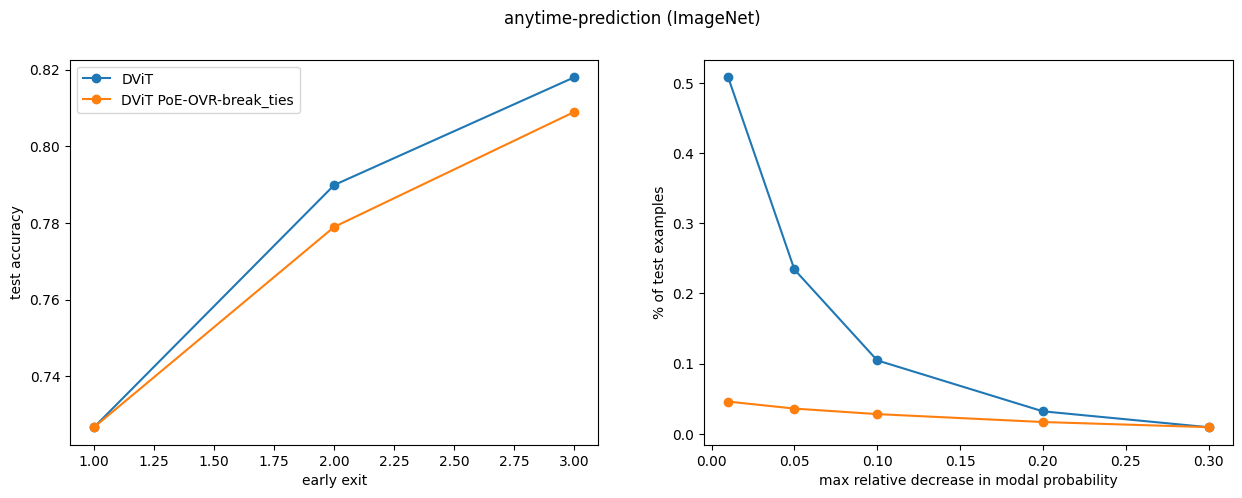

In [34]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='DViT', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='DViT PoE-OVR-break_ties', marker='o')
ax[0].legend()
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')


ax[1].plot(THRES, decreases_rel_probs, marker='o', label='DViT')
ax[1].plot(THRES, decreases_rel_probs_poe_ovr_break_ties, marker='o', label='DViT PoE-OVR-break_ties')
ax[1].set_xlabel('max relative decrease in modal probability')
ax[1].set_ylabel('% of test examples')

plt.suptitle(f'anytime-prediction (ImageNet)')
plt.show()